In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [5]:
df = pd.read_csv("bank_marketing.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (5581, 18)
   Unnamed: 0  age         job  marital  education default  balance housing  \
0           0   41    services  married    unknown      no       88     yes   
1           1   56  technician  married  secondary      no     1938      no   
2           2   30    services   single  secondary      no      245      no   
3           3   34  management   single   tertiary      no     1396     yes   
4           4   29  technician   single  secondary      no      -13     yes   

  loan   contact  day month  duration  campaign  pdays  previous poutcome  \
0   no  cellular   11   may       105         1    336         2  failure   
1  yes  cellular   26   feb       229         1    192         4  success   
2  yes  cellular    8   jul       187         2     -1         0  unknown   
3   no  cellular   17   jul       630         1     -1         0  unknown   
4   no  cellular   14   may       512         3     -1         0  unknown   

  deposit  
0      no  
1     yes  
2      n

In [7]:
df = df.dropna()

In [9]:
print(df.columns)

Index(['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'deposit'],
      dtype='object')


In [10]:
target_col = 'y' if 'y' in df.columns else 'deposit'

X = df.drop(target_col, axis=1)
y = df[target_col].map({'yes': 1, 'no': 0})

In [11]:
categorical = X.select_dtypes(include="object").columns
numeric = X.select_dtypes(exclude="object").columns

In [12]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical),
        ('num', numeric_transformer, numeric)
    ])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [14]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\n📊 Logistic Regression Results:\n")
print(classification_report(y_test, y_pred_lr))


📊 Logistic Regression Results:

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       598
           1       0.84      0.80      0.82       519

    accuracy                           0.83      1117
   macro avg       0.83      0.83      0.83      1117
weighted avg       0.83      0.83      0.83      1117



In [16]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n Random Forest Results:\n")
print(classification_report(y_test, y_pred_rf))


 Random Forest Results:

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       598
           1       0.83      0.86      0.85       519

    accuracy                           0.85      1117
   macro avg       0.85      0.85      0.85      1117
weighted avg       0.85      0.85      0.85      1117



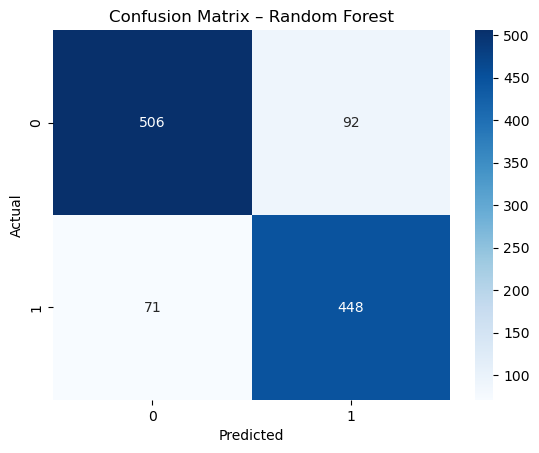

In [17]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

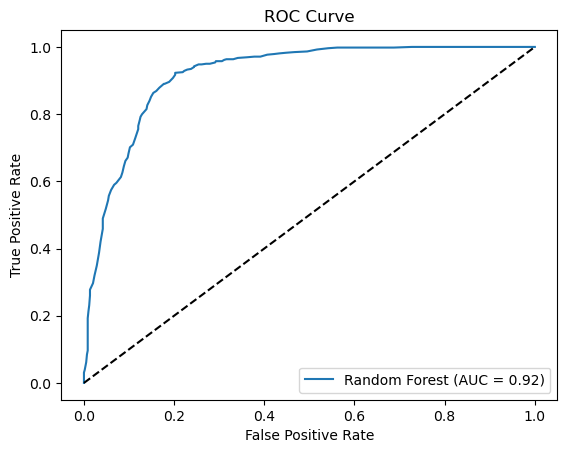

In [18]:
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)

plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_8120\3306934837.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


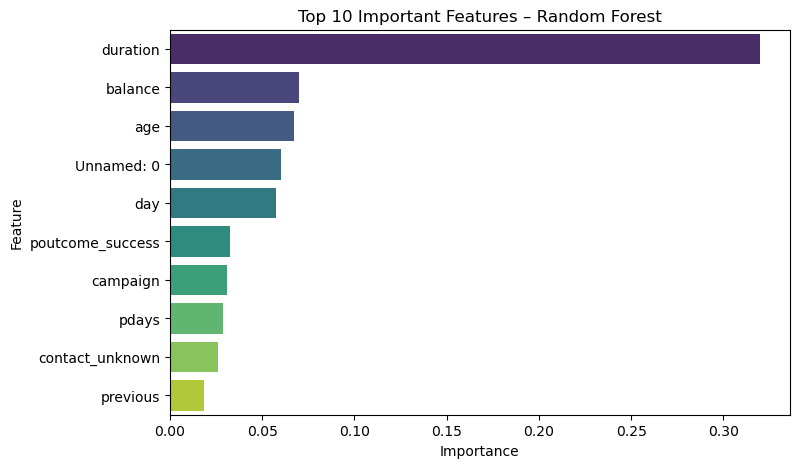

In [21]:
onehot_features = list(rf.named_steps['preprocessor']
                       .transformers_[0][1]
                       .get_feature_names_out(categorical))
all_features = onehot_features + list(numeric)

# Get feature importances from RandomForest
importances = rf.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("Top 10 Important Features – Random Forest")
plt.show()